In [11]:
import sqlite3
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Caminho do banco de dados
db_path = 'C:/Users/Dell/Documents/2-PROJETOS EMBARCADOS/LEITURA_MODBUS_SERIAL/modbus_data1.db'  # Caminho ajustado para o banco reorganizado

# Conexão com o banco de dados SQLite
con = sqlite3.connect(db_path)

# Consulta ajustada para obter valores de temperatura
query = "SELECT timestamp, value FROM reorganized_readings WHERE categoria = 'umidade'"

# Lê os dados do banco em um DataFrame
df = pd.read_sql_query(query, con)

# Fecha a conexão
con.close()

In [12]:
# ================================================
# 1) PRÉ-PROCESSAMENTO
# ================================================
# Remove valores nulos ou infinitos
df = df.dropna(subset=['value'])
df = df[df['value'].apply(np.isfinite)]

# Normaliza os dados para evitar influências de escala
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[['value']].values.reshape(-1, 1))

# Certifica-se de que o número de labels corresponde ao DataFrame
if len(data_scaled) != len(df):
    raise ValueError("O tamanho dos dados escalados não corresponde ao DataFrame original.")

# ================================================
# 2) APLICAÇÃO DO One-Class SVM
# ================================================
# Treinando o modelo One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)  # Ajuste de hiperparâmetros conforme necessário
svm.fit(data_scaled)
labels = svm.predict(data_scaled)

# Adiciona as informações ao DataFrame
df['Anomaly'] = (labels == -1)  # -1 indica anomalia

# ================================================
# 3) CÁLCULO DE PORCENTAGEM DE ANOMALIAS
# ================================================
total_readings = len(df)
total_anomalies = df['Anomaly'].sum()
anomaly_percentage = (total_anomalies / total_readings) * 100



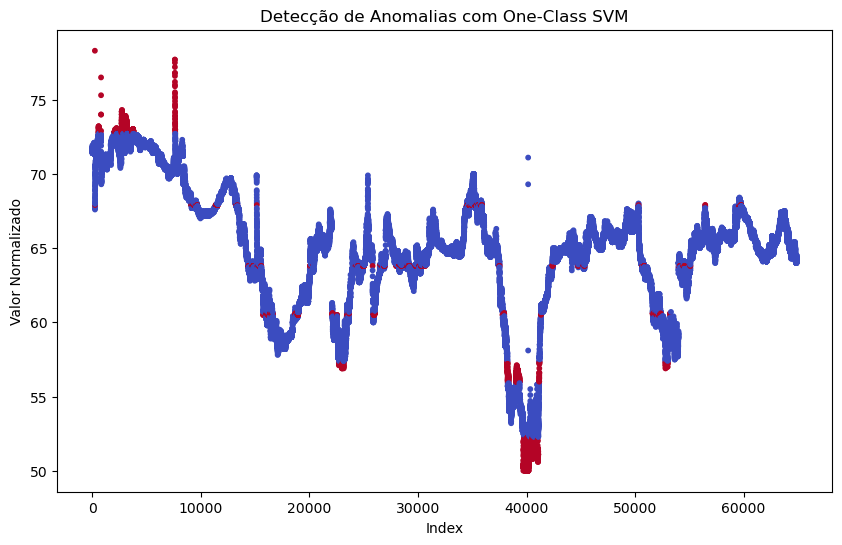

Leituras anômalas encontradas:
                 timestamp  value
242    2025-01-19 20:47:11   78.3
255    2025-01-19 20:48:23   67.9
582    2025-01-19 21:17:17   72.9
583    2025-01-19 21:17:22   72.8
584    2025-01-19 21:17:27   72.8
...                    ...    ...
59737  2025-01-25 01:33:11   67.9
59759  2025-01-25 01:35:24   67.9
59760  2025-01-25 01:35:29   67.9
59761  2025-01-25 01:35:34   67.9
59762  2025-01-25 01:35:39   67.9

[3320 rows x 2 columns]
Total de leituras: 64898
Total de anomalias: 3320
Porcentagem de possibilidade de anomalias: 5.12%


In [13]:
# ================================================
# 4) GRÁFICO DE DETECÇÃO DE ANOMALIAS
# ================================================
plt.figure(figsize=(10, 6))

# Gráfico de teste (anomalias)
plt.scatter(df.index, df['value'], c=df['Anomaly'], cmap='coolwarm', s=10)
plt.title('Detecção de Anomalias com One-Class SVM')
plt.xlabel('Index')
plt.ylabel('Valor Normalizado')
plt.show()

# ================================================
# 5) RELATÓRIO DE ANOMALIAS
# ================================================
anomalous_data = df[df['Anomaly']]
print("Leituras anômalas encontradas:")
print(anomalous_data[['timestamp', 'value']])
print(f"Total de leituras: {total_readings}")
print(f"Total de anomalias: {total_anomalies}")
print(f"Porcentagem de possibilidade de anomalias: {anomaly_percentage:.2f}%")